In [82]:
import torch
import pandas as pd
import numpy as np
from data_loader import CustomSignalData, CustomSignalData1
import seaborn as sns
from torch.autograd import Variable
import matplotlib.pyplot as plt
from encoder import Encoder as E
from helpers import get_data, get_all_data, get_shift_data1, get_operators, plot_cfs_mat, roll_data

In [83]:
DEVICE = torch.device("cpu")

# Data Import

In [84]:
X_0_train, y_0_train, X_0_test, y_0_test = get_data(0)
X_up_train, y_up_train, X_up_test, y_up_test = get_data(3)
X_down_train, y_down_train, X_down_test, y_down_test = get_data(4)
X_0_train.shape, X_up_train.shape, X_down_train.shape

((6677, 8), (6172, 8), (6252, 8))

In [85]:
h_X_train, h_y_train, h_shift_train = get_all_data(X_0_train, y_0_train)
h_X_test, h_y_test, h_shift_test = get_all_data(X_0_test, y_0_test)
h_X_train.shape, h_X_test.shape

((53416, 8), (37480, 8))

In [86]:
v_X_train, v_y_train, v_shift_train = get_all_data((X_up_train, X_0_train, X_down_train), (y_up_train, y_0_train, y_down_train),(1,0,-1))
v_X_test, v_y_test, v_shift_test = get_all_data((X_up_test, X_0_test, X_down_test), (y_up_test, y_0_test, y_down_test),(1,0,-1))
v_X_train.shape, v_X_test.shape

((19101, 8), (13968, 8))

In [87]:
X1_train, X2_train, h_train, v_train, triplet_y_train = get_shift_data1(h_X_train, v_X_train, h_shift_train, v_shift_train, h_y_train, v_y_train)
X1_test, X2_test, h_test, v_test, triplet_y_test = get_shift_data1(h_X_test, v_X_test, h_shift_test, v_shift_test, h_y_test, v_y_test)

X1_train.shape, X1_test.shape

((53416, 8), (37480, 8))

(array([7984.,    0., 8302.,    0., 7853.,    0., 8320.,    0.,    0.,
        7047.,    0., 8058.,    0., 8085.,    0., 8618.,    0., 8250.]),
 array([0.        , 0.44444444, 0.88888889, 1.33333333, 1.77777778,
        2.22222222, 2.66666667, 3.11111111, 3.55555556, 4.        ,
        4.44444444, 4.88888889, 5.33333333, 5.77777778, 6.22222222,
        6.66666667, 7.11111111, 7.55555556, 8.        ]),
 <BarContainer object of 18 artists>)

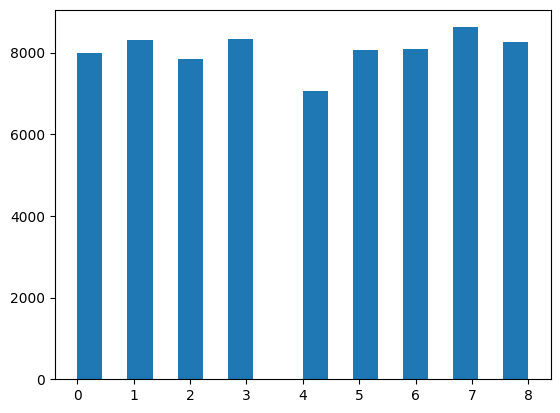

In [126]:
plt.hist(all_y_train, bins = 18)

# Data Loader 

In [89]:
def get_tensor(arr):
    return torch.tensor(arr, device=DEVICE,dtype=torch.float )

In [90]:
all_X_train = np.concatenate([h_X_train, v_X_train])
all_y_train = np.concatenate([h_y_train, v_y_train])

all_train_dataset = CustomSignalData(get_tensor(all_X_train), get_tensor(all_y_train))
alltrainloader = torch.utils.data.DataLoader(all_train_dataset, batch_size = 102, shuffle=True)

all_X_test = np.concatenate([h_X_test, v_X_test])
all_y_test = np.concatenate([h_y_test, v_y_test])

all_test_dataset = CustomSignalData(get_tensor(all_X_test), get_tensor(all_y_test))
alltestloader = torch.utils.data.DataLoader(all_test_dataset, batch_size = 100, shuffle=True)

triplet_train_dataset = CustomSignalData1(get_tensor(X1_train), get_tensor(X2_train), get_tensor(h_train), get_tensor(v_train), get_tensor(triplet_y_train))
triplettrainloader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size = 102, shuffle=True)

triplet_test_dataset = CustomSignalData1(get_tensor(X1_test), get_tensor(X2_test), get_tensor(h_test), get_tensor(v_test), get_tensor(triplet_y_test))
triplettestloader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size = 100, shuffle=True)

# Loss calculation

In [91]:
def clf_acc(model, loader, masks = None, encoder = None):
    model.eval()
    correct = 0
    iter = 0
    with torch.no_grad():
        for inputs, labels,_,_ in loader:
            inputs = inputs.to(DEVICE)
            if masks is not None:
                inputs = inputs * masks[:inputs.size()[0]]
            labels = labels.to(DEVICE)
            labels = labels.flatten()
            if encoder:
                pred = model(inputs, encoder)
            else:
                pred = model(inputs)
            correct += (1-torch.abs(torch.sign(torch.argmax(pred,dim = 1)- labels))).mean().item()
            iter += 1
    return correct/iter
            

In [92]:
# This function computes the accuracy on the test dataset
def compute_accuracy(a1,a2, b, o1, o2, loader):
    a1.eval()
    a2.eval()
    b.eval()
    o1.eval()
    o2.eval()
    
    correct = 0
    iter = 0
    
    with torch.no_grad():
        for x1, x2, deg1, deg2, labels,_ in loader:
            deg1 = -deg1.flatten().int()
            deg2 = -deg2.flatten().int()
            labels = labels.int().flatten()

            # forward + backward + optimize
            y1 = a1(x1)
            y1_tr = o1(y1,deg1)
            y1_tr = a2(y1_tr)

            # forward + backward + optimize
            y2 = a1(x2)
            y2_tr = a2(y2)
            y2_tr = o2(y2_tr,deg2)
            
            predicted_class1 = b(y1_tr)
            predicted_class2 = b(y2_tr)
            correct += (1.0-(predicted_class1.argmax(1)- labels).sign().abs()).mean().item()\
                       + (1.0-(predicted_class2.argmax(1)- labels).sign().abs()).mean().item()
            iter += 1

    return correct *0.5 / iter

# Training loop

## Logistic Regression

In [93]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(random_state=0, penalty='l2', # LASSO
                                solver='liblinear', C= 1000, # Suitable for LASSO
                                max_iter=5000).fit(all_X_train, all_y_train)
reg.score(all_X_test,all_y_test)

/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4472865806250972

In [94]:
accuracies = np.zeros([3,8])
vertical_ = zip([X_up_test,X_0_test, X_down_test],  [y_up_test,y_0_test, y_down_test])
for j, (X_, y_) in enumerate(vertical_):
    for i in range (-4, 4):
        X_test_shift = roll_data(X_, i)
        accuracies[j,i-4] = (reg.score(X_test_shift,y_))

<AxesSubplot:>

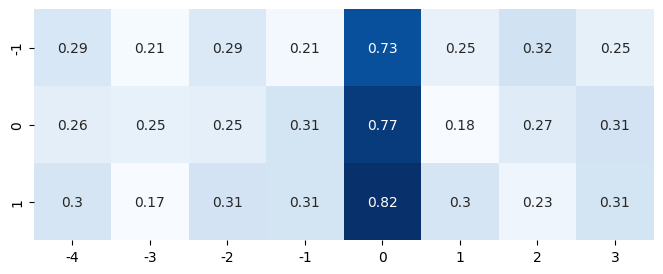

In [95]:
plt.figure(figsize=(8, 3), dpi=100)

df_cm = pd.DataFrame(accuracies , index = range(-1,2),
                  columns =range(-4,4) )

sns.heatmap(df_cm, annot=True,cmap='Blues', cbar=False,vmin=0.2, vmax=0.8 )

## Feed forward Neural Network

In [96]:
import torch
from torch.autograd import Variable
class FFNN(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(FFNN, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(inputSize, 9, bias=False),
            torch.nn.Sigmoid()
        )
        self.classifer = torch.nn.Sequential(
            torch.nn.Linear(9, outputSize, bias=False),
            # torch.nn.Softmax(dim=1)
        )

    def forward(self, x):
        z = self.encoder(x)
        class_z = self.classifer(z)
        return class_z

In [130]:
inputDim = 8     # takes variable 'x' 
outputDim = 9      # takes variable 'y'
learningRate = 0.001

model = FFNN(inputDim, outputDim)
model = model.to(DEVICE)
crit = torch.nn.CrossEntropyLoss()
acc_record = []
params_clf = list(model.parameters())# + list(encoder.parameters())
optim = torch.optim.Adam(params_clf, lr=learningRate)

In [131]:
DEVICE = torch.device("cpu")

In [161]:
epochs = 50
optim = torch.optim.Adam(params_clf, lr=0.01)
for epoch in range(epochs):
    model.train()

    # Converting inputs and labels to Variable
    for inputs, labels, _, _ in alltrainloader:
        with torch.no_grad():
            inputs = inputs.to(DEVICE)
            labels = labels.long().flatten().to(DEVICE)
            
        outputs = model(inputs, None)
        optim.zero_grad()
        losss = crit(outputs, labels) 
        losss.backward()
        optim.step()

    if not epoch %20:
        train_acc = clf_acc(model, alltrainloader,encoder= None)
        test_acc = clf_acc(model, alltestloader, encoder = None)
        acc_record +=  [(train_acc, test_acc)]
    if not epoch % 20:
        print('epoch {}, train {:.4} test {:.4}'.format(epoch, train_acc, test_acc))

epoch 0, train 0.845 test 0.7727
epoch 20, train 0.8465 test 0.7702
epoch 40, train 0.8459 test 0.7743


In [162]:
with torch.no_grad():
    accuracies_ffnn = np.zeros([3,8])

    vertical_ = zip([X_up_test,X_0_test, X_down_test], [y_up_test,y_0_test, y_down_test])
    for j, (X_, y_) in enumerate(vertical_):
        for i in range (-4, 4):
            X_test_shift = roll_data(X_, i)
            outputs = model(get_tensor(X_test_shift), None)
            accuracies_ffnn[j,i-4] = (1-torch.abs(torch.sign(torch.argmax(outputs,dim = 1)- y_))).mean()

<AxesSubplot:>

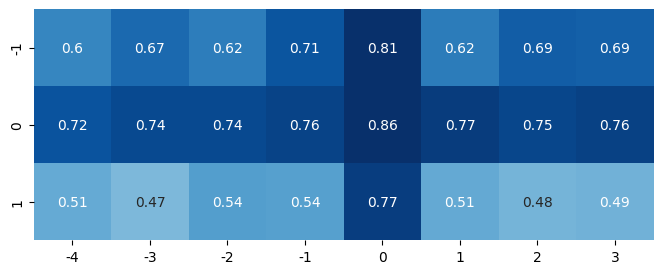

In [163]:
plt.figure(figsize=(8, 3), dpi=100)

df_cm = pd.DataFrame(accuracies_ffnn , index = range(-1,2),
                  columns =range(-4,4) )

sns.heatmap(df_cm, annot=True,cmap='Blues', cbar=False,vmin=0.2, vmax=0.8)

## Self-supervised

### Learned operator

In [102]:
import torch
import torch.nn as nn

class Operator1(nn.Module):
    def __init__(self, in_features, n_rotations1):
        super(Operator1, self).__init__()
        """
        Args:
          in_features (int): Number of input features which should be equal to xsize.
          out_features (out): Number of output features which should be equal to ysize.
        """
        self.in_features = in_features
        self.core1 = torch.nn.Parameter(torch.randn(in_features, in_features)/100)
        self.core1.requires_grad = True
        self.n_rotations1 = n_rotations1
        
    def rotate_batch(self, x, d):
      rotated = torch.empty(x.shape[0], x.shape[1])
      phies = [torch.linalg.matrix_power(self.core1,i) for i in range (self.n_rotations1)]
      for i in range (x.shape[0]):
        rotated[i] = phies[d[i]].matmul(x[i])
      return rotated

    def forward(self, x, d):
        """
        Args:
          x of shape (batch_size, 3, xsize, xsize): Inputs.
        
        Returns:
          y of shape (batch_size, 3*xsize^2): Outputs.
        """
        z = self.rotate_batch(x, d)
        return z

In [103]:
import torch
import torch.nn as nn

class Operator2(nn.Module):
    def __init__(self, in_features, n_rotations1,n_rotations2 ):
        super(Operator2, self).__init__()
        """
        Args:
          in_features (int): Number of input features which should be equal to xsize.
          out_features (out): Number of output features which should be equal to ysize.
        """
        self.in_features = in_features
        self.core = torch.nn.Parameter(torch.randn(in_features, in_features)/100)
        self.core.requires_grad = True
        self.n_rotations1 = n_rotations1
        self.n_rotations2 = n_rotations2
        
    def rotate_batch(self, x, d):
      rotated = torch.empty(x.shape[0], x.shape[1])
      phies = [torch.linalg.matrix_power(self.core,i) for i in range (2)]+[torch.linalg.matrix_power(self.core,-1)]
      for i in range (x.shape[0]):
        rotated[i] = phies[d[i]].matmul(x[i])
      return rotated

    def forward(self, x, d):
        """
        Args:
          x of shape (batch_size, 3, xsize, xsize): Inputs.
        
        Returns:
          y of shape (batch_size, 3*xsize^2): Outputs.
        """
        z = self.rotate_batch(x, d)
        return z

### Training

In [104]:
encoder1 = E(8,8)
encoder2 = E(8,8)

operator1 = Operator1(8,8)
operator2 = Operator2(8,1,1)

classifier = FFNN(8, 9)

parameters1 = list(encoder1.parameters()) + list(classifier.parameters())  + list(operator1.parameters())+ list(operator2.parameters())+ list(encoder2.parameters())

criterion1 = torch.nn.MSELoss()
criterion2 =  torch.nn.CrossEntropyLoss()

loss_record = []

In [105]:
optimizer1 = torch.optim.Adam(parameters1, lr=0.0005)


In [106]:
n_epochs = 100
identity = torch.eye(8)
for i in range(0,n_epochs):
  encoder1.train()
  operator1.train()
  model.train()
  encoder2.train()
  operator2.train()

  for x1, x2, deg1, deg2, labels, _ in triplettrainloader:
    with torch.no_grad():
      deg1 = -deg1.flatten().int() 
      deg2 = -deg2.flatten().int()
      labels = labels.long().flatten()
      
    y1 = encoder1(x1)
    y1_tr = operator1(y1,deg1)
    y1_tr = encoder2(y1_tr)

    y2 = encoder1(x2)
    y2_tr = encoder2(y2)
    y2_tr = operator2(y2_tr,deg2)

    predicted_class1 = classifier(y1_tr)
    predicted_class2 = classifier(y2_tr)
    
    # zero the parameter gradients
    optimizer1.zero_grad()
  
    loss =  criterion1(y1_tr,y2_tr) +  0.5*criterion2(predicted_class1, labels) + 0.5*criterion2(predicted_class2, labels)  \
      + 0.1* criterion1(identity,torch.linalg.matrix_power(operator1.core1,8)) #+ 0.1 * operator2.core.abs().mean()
      
    loss.backward()
    optimizer1.step()
  if not epoch %20:
    train_loss = compute_accuracy(encoder1, encoder2, classifier, operator1,operator2, triplettrainloader)
    test_loss = compute_accuracy(encoder1, encoder2, classifier, operator1,operator2, triplettestloader)
    loss_record +=  [(train_loss, test_loss)]
    print("Epoch {}/{}: train acc {:.4} test acc {:.4}".format(i, n_epochs,train_loss, test_loss))

Epoch 0/100: train acc 0.1398 test acc 0.1242
Epoch 1/100: train acc 0.1361 test acc 0.1419
Epoch 2/100: train acc 0.1396 test acc 0.1246
Epoch 3/100: train acc 0.1398 test acc 0.1246
Epoch 4/100: train acc 0.1398 test acc 0.1255
Epoch 5/100: train acc 0.1311 test acc 0.1199
Epoch 6/100: train acc 0.1881 test acc 0.1794
Epoch 7/100: train acc 0.1853 test acc 0.1786
Epoch 8/100: train acc 0.2121 test acc 0.2011
Epoch 9/100: train acc 0.2164 test acc 0.2025
Epoch 10/100: train acc 0.2587 test acc 0.2434
Epoch 11/100: train acc 0.2941 test acc 0.2827
Epoch 12/100: train acc 0.3166 test acc 0.312
Epoch 13/100: train acc 0.3494 test acc 0.3536
Epoch 14/100: train acc 0.4032 test acc 0.3952
Epoch 15/100: train acc 0.4483 test acc 0.4348
Epoch 16/100: train acc 0.498 test acc 0.4754
Epoch 17/100: train acc 0.5585 test acc 0.5191
Epoch 18/100: train acc 0.5769 test acc 0.537
Epoch 19/100: train acc 0.6026 test acc 0.5586
Epoch 20/100: train acc 0.6326 test acc 0.5829
Epoch 21/100: train acc 0.

In [107]:
torch.linalg.matrix_power(operator2.core,-1)

tensor([[ 0.5286,  7.4043,  2.7938, -7.7402,  1.1389, -0.6780, -0.6010, -5.9115],
        [-1.6812,  4.6765,  1.5203, -8.0676, -1.2178,  2.1480, -0.3580, -2.0759],
        [ 3.1435,  2.0308,  0.4552, -2.9771,  1.1919,  3.8742,  1.7780,  1.8698],
        [-0.1492,  2.9973, -1.2751, -0.0407, -0.5966, -1.8586, -0.0627, -0.6918],
        [ 1.3423,  3.6524,  1.0740, -6.9460,  1.5391,  3.6296,  1.1017, -0.3000],
        [ 0.8002,  4.3193,  2.3099, -4.0667,  1.9813,  2.5191, -0.2665, -3.0032],
        [ 1.7749,  1.6979,  0.9931, -1.5520,  1.3862,  1.7683,  1.5512, -0.3681],
        [-1.6783, -1.9668, -0.5593,  3.6398, -0.7229, -3.2514, -0.8841,  0.3508]],
       grad_fn=<LinalgInvExBackward0>)

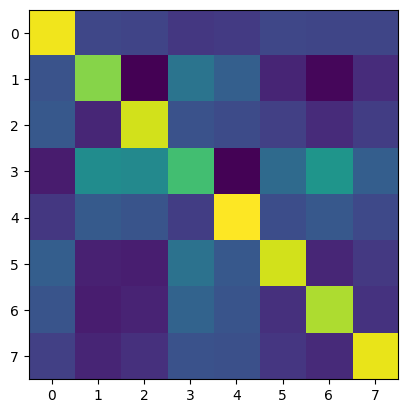

In [127]:
plt.imshow(torch.linalg.matrix_power(operator1.core1,8).detach().numpy())

In [128]:
with torch.no_grad():
    encoder1.eval()
    operator1.eval()
    classifier.eval()
    encoder2.eval()
    operator2.eval()
    
    accuracies_operator = np.zeros([3,8])
    

    vertical_ = zip([X_up_test,X_0_test, X_down_test], [y_up_test,y_0_test, y_down_test])
    
    for j, (X_, y_) in enumerate(vertical_):
        for i in range (-4, 4):
            X_test_shift = roll_data(X_, i)
            y1 = encoder1(get_tensor(X_test_shift))
            y1_tr = operator1(y1, -torch.ones(y_.shape[0]).int() * i)
            y1_tr = encoder2(y1_tr)
            y1_tr = operator2(y1_tr,j*torch.ones(y_.shape[0]).int() -1)
            predicted_class1 = classifier(y1_tr).argmax(1).flatten()
            accuracies_operator[j,i-4] = (1-torch.abs(torch.sign(predicted_class1- y_))).mean()

<AxesSubplot:>

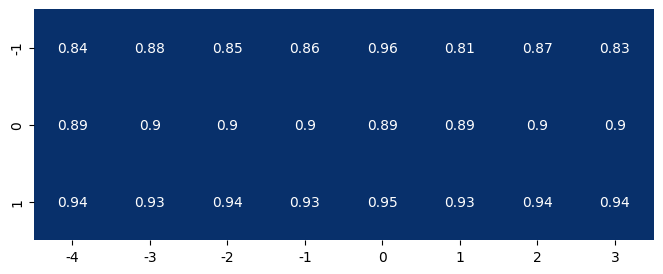

In [129]:
plt.figure(figsize=(8, 3), dpi=100)

df_cm = pd.DataFrame(accuracies_operator , index = range(-1,2),
                  columns =range(-4,4) )

sns.heatmap(df_cm, annot=True,cmap='Blues', cbar=False,vmin=0.2, vmax=0.8 )

In [215]:
with torch.no_grad():
    encoder1.eval()
    operator1.eval()
    classifier.eval()
    encoder2.eval()
    operator2.eval()

    N_points = 1000

    h_rand_idx = np.random.choice(h_X_train.shape[0], N_points)
    y_tr = encoder1(get_tensor(h_X_train[h_rand_idx]))
    y_tr = operator1(y_tr, -h_shift_train[h_rand_idx].flatten())
    h_recovered_points_ = encoder2(y_tr)
    del y_tr

    v_rand_idx = np.random.choice(v_X_train.shape[0], N_points)
    y_tr = encoder1(get_tensor(v_X_train[v_rand_idx]))
    y_tr = encoder2(y_tr)
    v_recovered_points_ = operator2(y_tr, -v_shift_train[v_rand_idx].flatten())
    del y_tr
    
    accuracies_inferred_operator = np.zeros([3,8])
    
    vertical_ = zip([X_up_test, X_0_test, X_down_test], [y_up_test, y_0_test, y_down_test])
    
    for j, (X_, y_) in enumerate(vertical_):
        for i in range (-4, 4):
            X_test_shift = roll_data(X_, i)
            y1 = encoder1(get_tensor(X_test_shift))
            #y_tr_est1 = operator1(y1, -torch.ones(y_.shape[0]).int() * i)
            
            y_tr_rotated = torch.zeros(y1.shape[0])

            phies = [torch.linalg.matrix_power(operator1.core1,i) for i in range (8)]
            for z, y__ in enumerate(y1):
                distances = np.zeros(8)
                for d in (range(-4,4)):
                    x_rotated = phies[d].matmul(y__).repeat(N_points,1)
                    distances[d] = ((x_rotated-h_recovered_points_)**2).mean(1).topk(10, largest=False)[0].mean()
                y_tr_rotated[z] = distances.argmin()
            print((y_tr_rotated+i), 1-torch.abs(torch.sign(y_tr_rotated+i)).mean())
            y_tr_est1 = operator1(y1, y_tr_rotated.int())
            y_tr_est1 = encoder2(y_tr_est1)

            y_tr_rotated = torch.zeros(y1.shape[0])

            phies = [torch.linalg.matrix_power(operator2.core,i) for i in range (2)]+[torch.linalg.matrix_power(operator2.core,-1)]
            for z, y__ in enumerate(y_tr_est1):
                distances = np.zeros(3)
                for d in (range(-1,2)):
                    x_rotated = phies[d].matmul(y__).repeat(N_points,1)
                    distances[d] = ((x_rotated-v_recovered_points_)**2).mean(1).topk(2, largest=False)[0].mean()
                y_tr_rotated[z] = distances.argmin()
            y_tr_est1 = operator2(y_tr_est1, y_tr_rotated.int())
            y_tr1 = classifier(y_tr_est1).argmax(1)
            accuracies_inferred_operator[j, i-4] = 1-torch.abs(torch.sign(y_tr1- y_)).mean()

<AxesSubplot:>

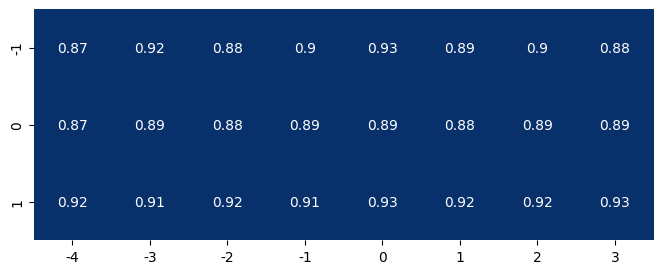

In [216]:
plt.figure(figsize=(8, 3), dpi=100)

df_cm = pd.DataFrame(accuracies_inferred_operator , index = range(-1,2),
                  columns =range(-4,4) )

sns.heatmap(df_cm, annot=True,cmap='Blues', cbar=False,vmin=0.2, vmax=0.8 )